In [1]:
%matplotlib notebook
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.environ.setdefault('GLUE_SETTINGS_MODULE', 'settings')

'settings'

In [3]:
import net_classify
from flowfairy.conf import settings

In [4]:
batch_size = settings.BATCH_SIZE
samplerate = settings.SAMPLERATE

In [5]:
x = tf.placeholder(tf.float32, [64, samplerate])
cls = tf.placeholder(tf.int32, 64)

In [6]:
with tf.variable_scope('network'):
    net = net_classify.conv_net(x, cls, None)

conv1:  Tensor("network/MaxPool2D/MaxPool:0", shape=(64, 5512, 1, 4), dtype=float32)
embedded: Tensor("network/embedding/concat:0", shape=(64, 5512, 1, 5), dtype=float32)
conv2:  Tensor("network/MaxPool2D_1/MaxPool:0", shape=(64, 2756, 1, 16), dtype=float32)
conv3:  Tensor("network/mul_2:0", shape=(64, 2756, 1, 16), dtype=float32)
d2sp:  Tensor("network/DepthToSpace:0", shape=(64, 11024, 4, 1), dtype=float32)
conv4:  Tensor("network/mul_3:0", shape=(64, 11024, 1, 16), dtype=float32)
conv5:  Tensor("network/mul_4:0", shape=(64, 11024, 1, 256), dtype=float32)
out:  Tensor("network/Reshape_1:0", shape=(64, 11024, 256), dtype=float32)


In [7]:
saver = tf.train.Saver()

In [8]:
sess = tf.InteractiveSession()

In [9]:
saver.restore(sess, tf.train.latest_checkpoint('logs'))

INFO:tensorflow:Restoring parameters from /home/s123859/flowfairy/examples/sine_fix/logs/GLU_nnnorm_causal.ckpt-9000


In [10]:
coll = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
c1uw = coll[0]

In [11]:
def plot_filter(var, flt):
    plt.plot(var.eval()[:,0,0,flt])

<IPython.core.display.Javascript object>


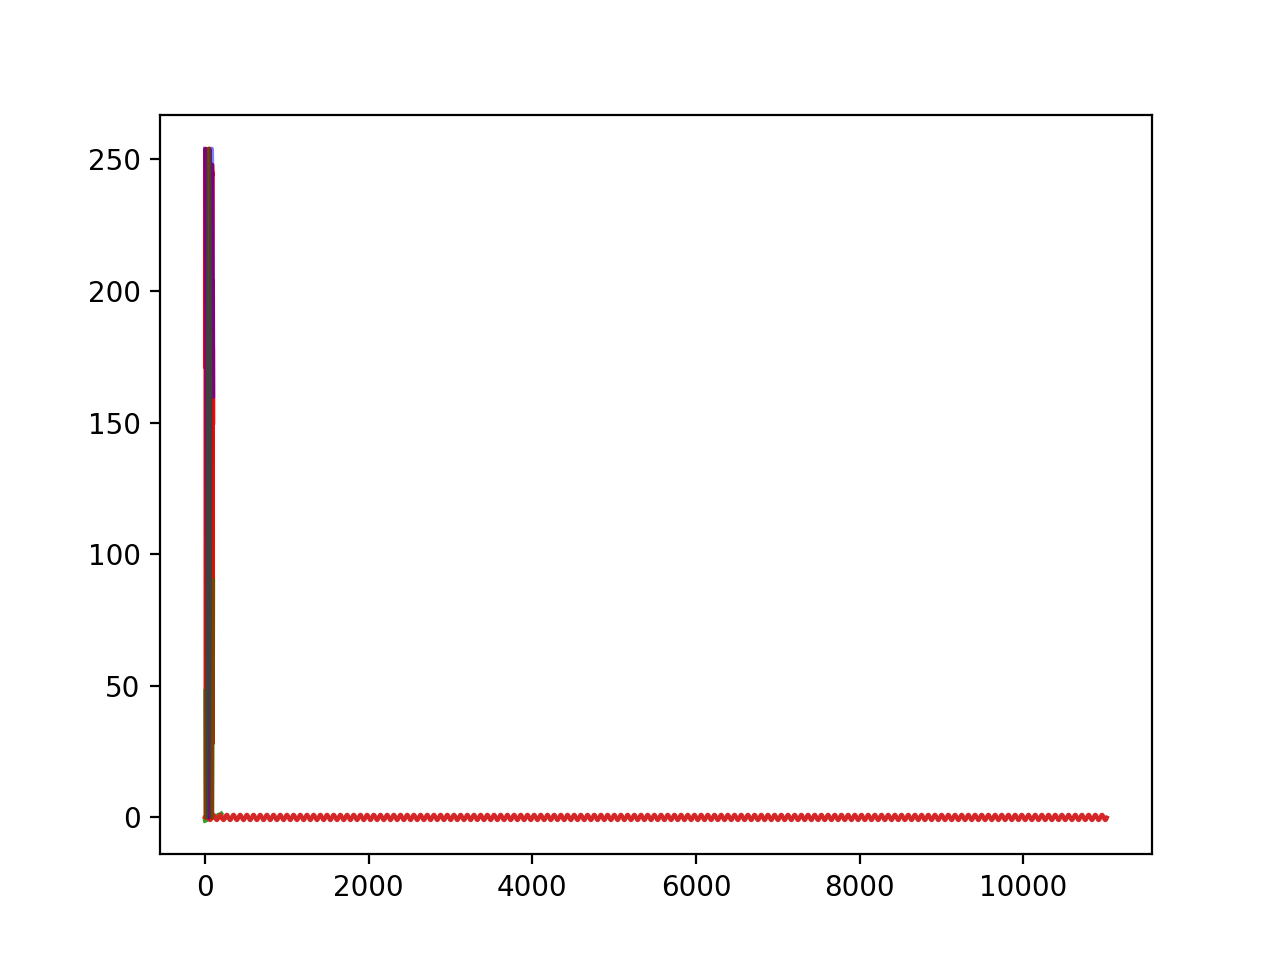

In [12]:
#plot_filter(c1uw, 0)
#plot_filter(c1uw, 1)
plot_filter(c1uw, 2)
plot_filter(c1uw, 3)
#plt.show()

In [13]:
for v in coll:
    print(v)

<tf.Variable 'network/conv1_unit/weights:0' shape=(256, 1, 1, 4) dtype=float32_ref>
<tf.Variable 'network/conv1_unit/BatchNorm/beta:0' shape=(4,) dtype=float32_ref>
<tf.Variable 'network/conv1_gate/weights:0' shape=(256, 1, 1, 4) dtype=float32_ref>
<tf.Variable 'network/conv1_gate/BatchNorm/beta:0' shape=(4,) dtype=float32_ref>
<tf.Variable 'network/embedding/embedding_1:0' shape=(200, 1) dtype=float32_ref>
<tf.Variable 'network/conv2_unit/weights:0' shape=(128, 1, 5, 16) dtype=float32_ref>
<tf.Variable 'network/conv2_unit/BatchNorm/beta:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'network/conv2_gate/weights:0' shape=(128, 1, 5, 16) dtype=float32_ref>
<tf.Variable 'network/conv2_gate/BatchNorm/beta:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'network/conv3_unit/weights:0' shape=(128, 1, 16, 16) dtype=float32_ref>
<tf.Variable 'network/conv3_unit/biases:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'network/conv3_gate/weights:0' shape=(128, 1, 16, 16) dtype=float32_ref>
<tf.Varia

In [14]:
embedding = coll[4][:,0]
print(embedding)
plt.plot(sorted(embedding.eval()))
#plt.show()

print(embedding.eval()[5])

Tensor("strided_slice:0", shape=(200,), dtype=float32)
1.03878


In [15]:
def classify(val):
    val = (val-np.min(val))/(np.max(val)-np.min(val))
    return np.floor(val*255)


In [16]:
myrange = np.arange(samplerate) / samplerate
mysine = np.sin(myrange * np.pi * 2 * 135)
mysine2 = np.sin(myrange * np.pi * 2 * 150)

plt.plot(mysine)
plt.show()

In [17]:
print(mysine.shape)
print(np.array([mysine]).shape)

(11024,)
(1, 11024)


In [31]:
pred = tf.argmax(net, 2)
b=np.tile(classify(mysine+mysine2),(64,1))
y=np.arange(136,200)
run = sess.run(pred, feed_dict={x: b, cls: y})

<IPython.core.display.Javascript object>


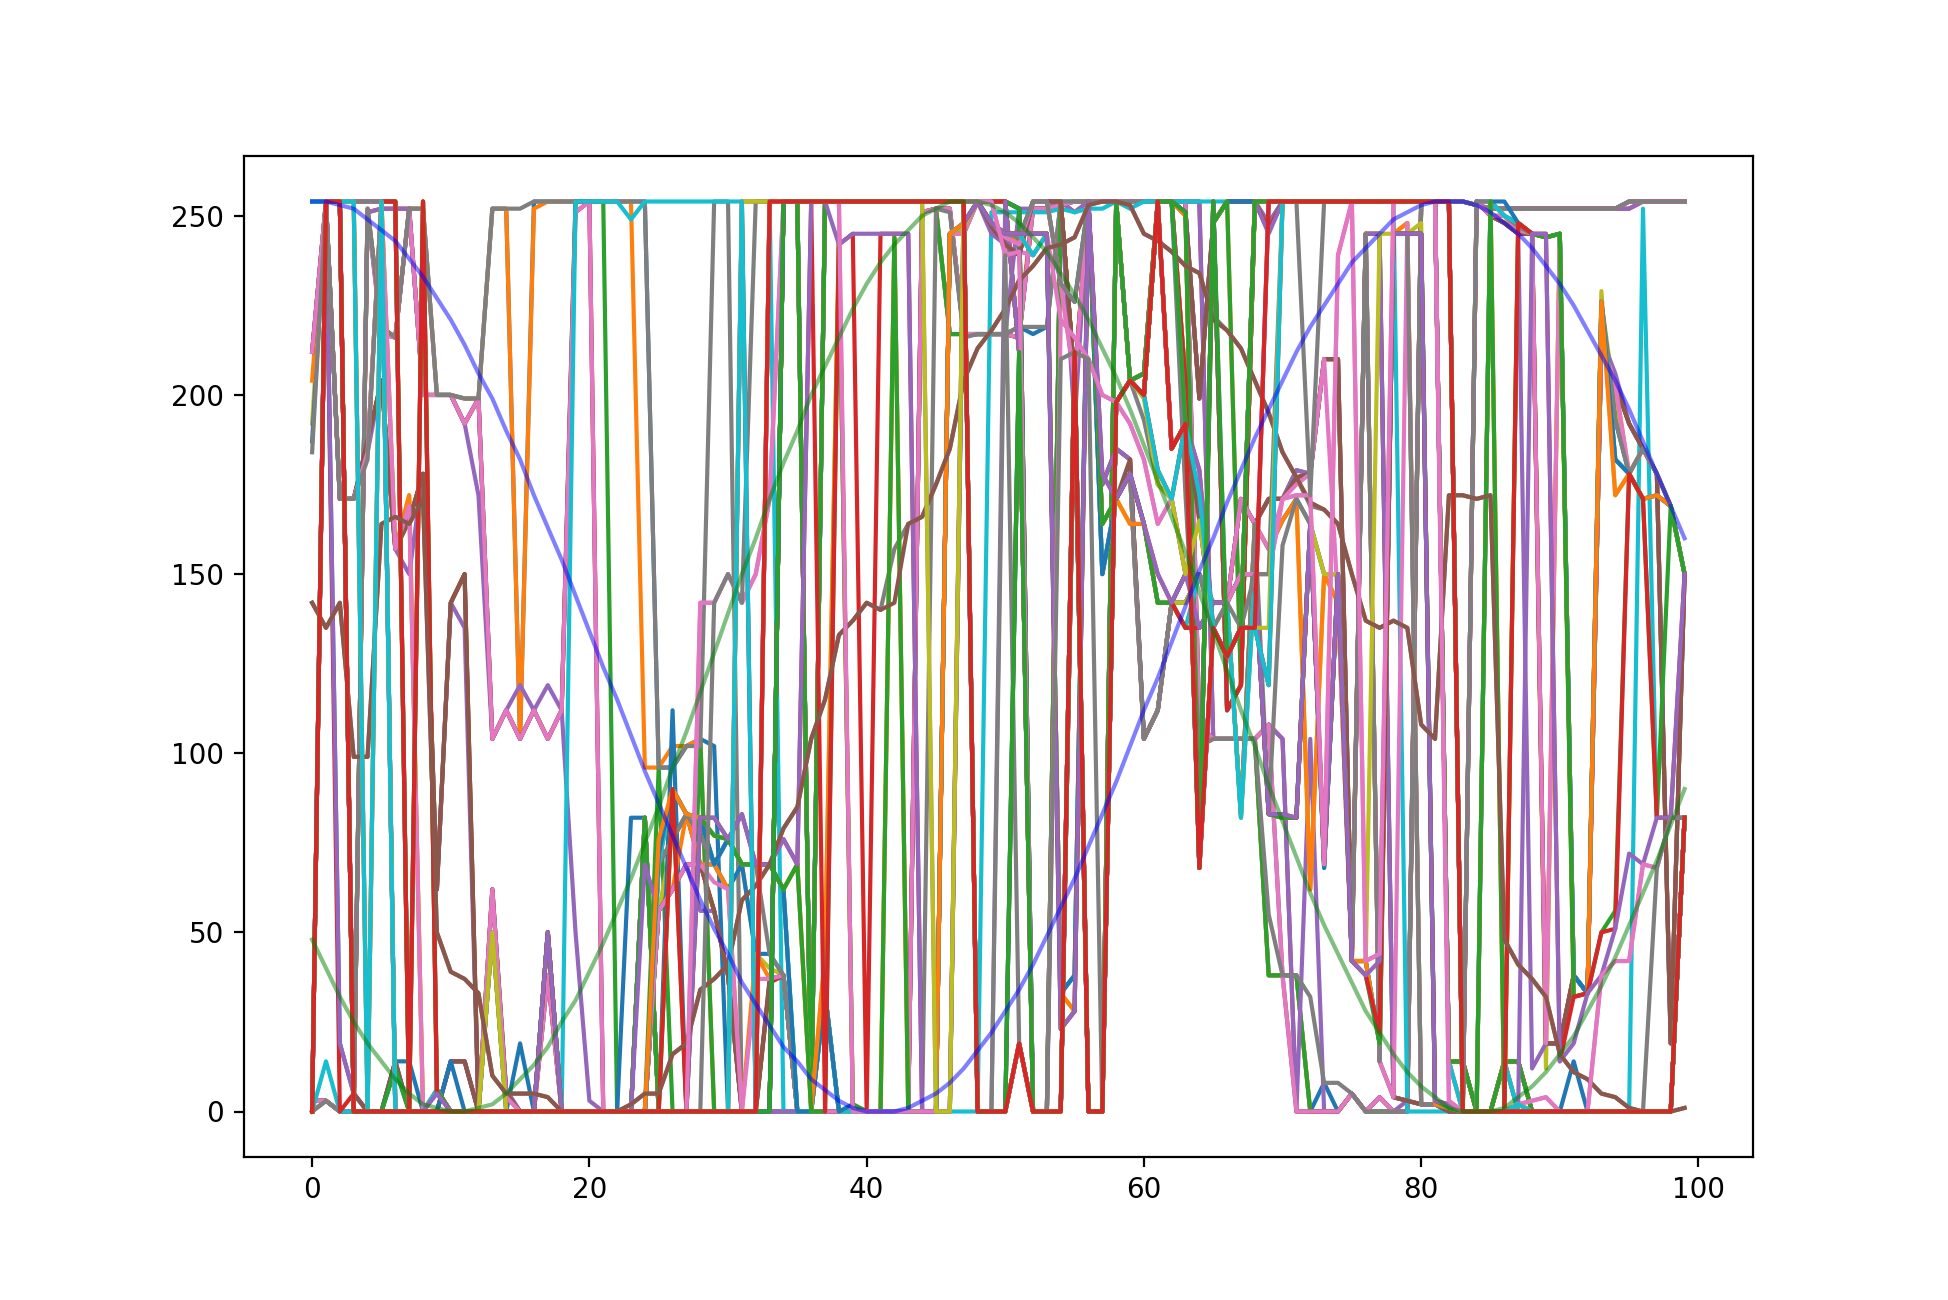

In [32]:

[plt.plot(run[1000:1100]) for run in run]
plt.plot(classify(mysine)[1000:1100], 'b', alpha=0.5)
plt.plot(classify(mysine2)[1000:1100], 'g', alpha=0.5)
plt.show()

In [20]:
(150-120)/3


10.0